# Forecasting of future changes

**Author:** M.G. Baltussen

**Estimated running time:** 1 minute

**Generated output:**
```
plots/forecast_schematic.{svg,png} (manuscript figure 4)
plots/forecast_results.{svg,png} (manuscript figure 4)
plots_extended/forecast_results_extended.{svg,png}
```

In [1]:
""" System imports """
import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.75, 
rc={
    "axes.linewidth": 0.5,     
    'axes.facecolor':'#eceff4', 
    'axes.edgecolor':'#2e3440',
    'axes.labelcolor':'#2e3440',
    'text.color': '#2e3440',
    'xtick.color': '#2e3440',
    'ytick.color': '#2e3440',
    'font.family': 'Arial',
    'svg.fonttype': 'none',
    })
import colorcet as cc

nord_palette = [
    "#bf616a","#d08770","#ebcb8b","#a3be8c","#b48ead",
    "#8fbcbb","#88c0d0","#81a1c1","#5e81ac",
    "#2e3440","#3b4252","#434c5e","#4c566a",
    "#d8dee9","#e5e9f0","#eceff4",
]

sns.set_palette(nord_palette)

def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)

def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)


In [2]:
df_lorenz = pd.read_csv("../data/lorenz.csv", index_col=0)
U_lorenz = df_lorenz[['DHA', 'NaOH', 'formaldehyde']]
X_lorenz = df_lorenz.drop(columns=['DHA', 'NaOH', 'CaCl2', 'formaldehyde'])

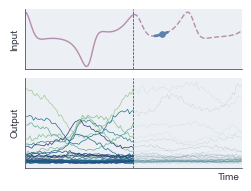

In [3]:
fig, axes = plt.subplots(2,1, figsize=(2.4, 1.8), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [2,3]})

sampled_X = X_lorenz.sample(n=40, axis=1, random_state=7)
sns.lineplot(data=sampled_X[120:180], ax=axes[1], palette='crest', legend=None, lw=0.5, dashes=False)
sns.lineplot(data=sampled_X[179:240], ax=axes[1], palette='crest', legend=None, lw=0.2, alpha=0.5, dashes=True)
axes[1].set_yticks([])
axes[1].set_ylabel("Output")
axes[1].set_xlabel("Time")
axes[1].xaxis.set_label_coords(0.94, -0.05)
c = "#b48ead"
axes[0].plot(U_lorenz.index[120:180], U_lorenz.values[120:180,0], alpha=1.0, lw=1, color=c)
axes[0].plot(U_lorenz.index[179:240], U_lorenz.values[179:240,0], alpha=1.0, lw=1, ls='dashed', color=c)
axes[0].plot(U_lorenz.index[179+12:179+20],  U_lorenz.values[179+12:179+20,0], alpha=1.0, lw=2.0, color='C8')
axes[0].scatter(U_lorenz.index[179+16], U_lorenz.values[179+16,0], color='C8', s=16)
axes[0].scatter(U_lorenz.index[35], U_lorenz.values[35,0], color=c, s=2)
axes[0].plot(U_lorenz.index[39+8:39+16], U_lorenz.values[39+8:39+16,0], alpha=1.0, lw=1.2, color='C2')

axes[0].set_xticks([0, 1800, 3600, 7200, 10800], [0, 0.5, 1, 2, 3])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlim(120*10, 240*10)
axes[0].set_ylabel("Input")

axes[0].axvline(U_lorenz.index[180-1], color='C9', lw=0.5, ls='dashed')
axes[1].axvline(U_lorenz.index[180-1], color='C9', lw=0.5, ls='dashed')


sns.despine()
save_plot("forecast_schematic")
plt.show()


# Training

In [4]:
N_future = 12
N_skip = 60
N_train = 180 + N_skip

N_test = 1200 + N_train

def nmse(y_pred, y_true):
    return ((y_pred - y_true)**2).sum()/((y_true - y_true.mean())**2).sum()

index = U_lorenz.index
train_data = X_lorenz.loc[index].values

reg = linear_model.Ridge(alpha=0.5*1e-4)
reg.fit(train_data[N_skip:N_train], U_lorenz[N_skip+N_future:N_train+N_future])

U_train = reg.predict(train_data[N_skip:N_train])
U_pred = reg.predict(train_data[N_train:N_test])
train_mse = nmse(U_train, U_lorenz[N_skip+N_future:N_train+N_future])
test_mse = nmse(U_pred, U_lorenz[N_train+N_future:N_test+N_future])
print(f"train MSE:\n{train_mse}, test MSE:\n{test_mse}")



train MSE:
DHA             0.143950
NaOH            0.031844
formaldehyde    0.507459
dtype: float64, test MSE:
DHA             0.310624
NaOH            0.105262
formaldehyde    0.716825
dtype: float64


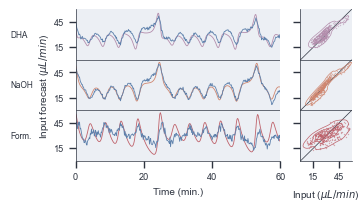

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(3.5,2.0), constrained_layout=True, sharey=True, gridspec_kw={'width_ratios': [8,2]})

for i, c in zip([2,1,0],["#bf616a","#d08770","#b48ead"]):

    axes[0].plot(index, (2-i)*60  + U_lorenz.values[:,i], label="Input", c=c, alpha=1.0, lw=0.6)
    axes[0].plot(index[N_skip+N_future:N_train+N_future], (2-i)*60 + U_train[:,i], c='C2', label="training", lw=0.6, alpha=1.0)
    axes[0].plot(index[N_train+N_future:N_test+N_future], (2-i)*60 + U_pred[:,i], c='C8', label="predicted", lw=0.6, alpha=1.0)

axes[0].text(-0.32, 1/6, "Form.", transform=axes[0].transAxes, va='center', fontsize='small')
axes[0].text(-0.32, 3/6, "NaOH", transform=axes[0].transAxes, va='center', fontsize='small')
axes[0].text(-0.32, 5/6, "DHA", transform=axes[0].transAxes, va='center', fontsize='small')
axes[0].yaxis.set_label_coords(-0.12, 0.5)

axes[0].set_ylabel(r"Input forecast ($\mu L/min$)")
axes[0].set_yticks([])
axes[0].set_yticks([15, 45, 75, 105, 135, 165], [15, 45, 15, 45, 15, 45])
axes[0].axhline(60, color='C9', lw=0.5)
axes[0].axhline(120, color='C9', lw=0.5)
axes[0].set_ylim(0, 180)
axes[0].set_xticks([2520, 2520+1200, 2520+2400, 2520+3600, 7200, 10800], [0, 20, 40, 60, 2, 3])
axes[0].set_xlim(2520, 2520+3600)
axes[0].set_xlabel("Time (min.)")

axes[1].plot([0,60],[0,60], color='C9', lw=0.5)
axes[1].plot([0,60],[60,120], color='C9', lw=0.5)
axes[1].plot([0,60],[120,180], color='C9', lw=0.5)
axes[1].axhline(60, color='C9', lw=0.5)
axes[1].axhline(120, color='C9', lw=0.5)
for i, (idx, c) in enumerate(zip(["DHA", "NaOH", 'formaldehyde'], ["#b48ead", "#d08770","#bf616a"])):
    sns.kdeplot(ax=axes[1], y=(2-i)*60 +U_pred[:360, i], x=U_lorenz.values[N_train+N_future:N_train+N_future + 360, i], zorder=10-i, 
                fill=False, color=c, alpha=1.0, levels=4, linewidths=0.5)
    axes[1].scatter(U_lorenz.values[N_train+N_future:N_train+N_future + 360, i], (2-i)*60 + U_pred[:360, i], color=c, s=1.0, lw=0, alpha=0.5, zorder=20-i)
axes[1].set_xticks([15, 45])
axes[1].set_xlim(0, 60)
axes[1].set_xlabel(r"Input ($\mu L/min$)")

sns.despine()
save_plot("forecast_results")

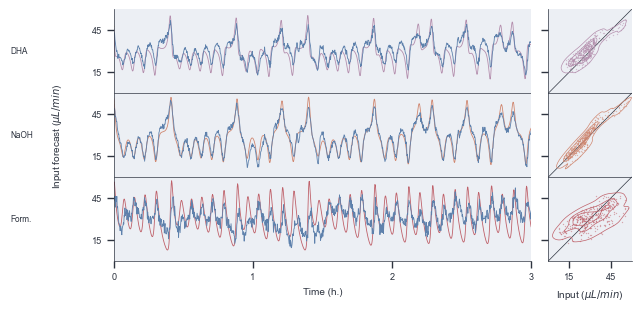

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(6.3,3.0), constrained_layout=True, sharey=True, gridspec_kw={'width_ratios': [5,1]})

for i, c in zip([2,1,0],["#bf616a","#d08770","#b48ead"]):

    axes[0].plot(index, (2-i)*60  + U_lorenz.values[:,i], label="Input", c=c, alpha=1.0, lw=0.6)
    axes[0].plot(index[N_skip+N_future:N_train+N_future], (2-i)*60 + U_train[:,i], c='C2', label="training", lw=0.6, alpha=1.0)
    axes[0].plot(index[N_train+N_future:N_test+N_future], (2-i)*60 + U_pred[:,i], c='C8', label="predicted", lw=0.6, alpha=1.0)

axes[0].text(-0.25, 1/6, "Form.", transform=axes[0].transAxes, va='center', fontsize='small')
axes[0].text(-0.25, 3/6, "NaOH", transform=axes[0].transAxes, va='center', fontsize='small')
axes[0].text(-0.25, 5/6, "DHA", transform=axes[0].transAxes, va='center', fontsize='small')
axes[0].yaxis.set_label_coords(-0.12, 0.5)

axes[0].set_ylabel(r"Input forecast ($\mu L/min$)")
axes[0].set_yticks([])
axes[0].set_yticks([15, 45, 75, 105, 135, 165], [15, 45, 15, 45, 15, 45])
axes[0].axhline(60, color='C9', lw=0.5)
axes[0].axhline(120, color='C9', lw=0.5)
axes[0].set_ylim(0, 180)
axes[0].set_xticks([2520, 2520+3600, 2520+7200, 2520+10800], [0, 1, 2, 3])
axes[0].set_xlim(2520, 2520+10800)
axes[0].set_xlabel("Time (h.)")

axes[1].plot([0,60],[0,60], color='C9', lw=0.5)
axes[1].plot([0,60],[60,120], color='C9', lw=0.5)
axes[1].plot([0,60],[120,180], color='C9', lw=0.5)
axes[1].axhline(60, color='C9', lw=0.5)
axes[1].axhline(120, color='C9', lw=0.5)
for i, (idx, c) in enumerate(zip(["DHA", "NaOH", 'formaldehyde'], ["#b48ead", "#d08770","#bf616a"])):
    sns.kdeplot(ax=axes[1], y=(2-i)*60 +U_pred[:360, i], x=U_lorenz.values[N_train+N_future:N_train+N_future + 360, i], zorder=10-i, 
                fill=False, color=c, alpha=1.0, levels=4, linewidths=0.5)
    axes[1].scatter(U_lorenz.values[N_train+N_future:N_train+N_future + 360, i], (2-i)*60 + U_pred[:360, i], color=c, s=1.0, lw=0, alpha=0.5, zorder=20-i)
axes[1].set_xticks([15, 45])
axes[1].set_xlim(0, 60)
axes[1].set_xlabel(r"Input ($\mu L/min$)")

sns.despine()
save_si("forecast_results_extended")